# Data Processing

In [ ]:
# from google.colab import drive

In [ ]:
# drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd Downloads

/var/autofs/misc/home/ahmedt/Downloads


/usr/local/lib/python3.11/aims/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [16]:
pwd

'/var/autofs/misc/home/ahmedt/Downloads'

In [17]:
f = open('ml-25m/ratings.csv', 'r')
lines = f.readlines()[1:]

In [18]:
ratings_data = []
for line in lines:
  user, movie, rating, _ = line.split(',')
  user, movie, rating = int(user), int(movie), float(rating)
  ratings_data.append((user, movie, rating))

In [19]:
import numpy as np
ratings_data = np.array(ratings_data)
np.random.shuffle(ratings_data)

In [20]:
ratings = ratings_data

In [21]:
import random

In [22]:
class Ratings_DS():
  def __init__(self, ratings):
    idx_to_user = []
    idx_to_movie = []
    user_to_idx = {}
    movie_to_idx = {}
    self.train_users_list = []
    self.train_movies_list = []
    self.test_users_list = []
    self.test_movies_list = []

    for user, movie, rating in ratings:
      if user not in user_to_idx:
        idx_to_user.append(user)
        self.train_users_list.append([])
        self.test_users_list.append([])
        user_to_idx[user] = len(idx_to_user) - 1
      if movie not in movie_to_idx:
        idx_to_movie.append(movie)
        self.train_movies_list.append([])
        self.test_movies_list.append([])
        movie_to_idx[movie] = len(idx_to_movie) - 1

      userIdx = user_to_idx[user]
      movieIdx = movie_to_idx[movie]
      if random.random() > 0.1:
        self.train_users_list[userIdx].append((movieIdx, rating))
        self.train_movies_list[movieIdx].append((userIdx, rating))
      else:
        self.test_users_list[userIdx].append((movieIdx, rating))
        self.test_movies_list[movieIdx].append((userIdx, rating))

  # Creating a dummy user
  def create_dummy(self, movieIdx):
    self.train_users_list.append([(movieIdx, 5)])
    userIdx = len(self.train_movies_list) - 1
    self.train_movies_list[100].append((userIdx, 5))
    self.test_users_list.append([])

  def get_movies_by_user(self, user, train=True):
    if train:
      return self.train_users_list[user]
    return self.test_users_list[user]

  def get_users_by_movie(self, movie, train=True):
    if train:
      return self.train_movies_list[movie]
    return self.test_movies_list[movie]




In [23]:
my_ds = Ratings_DS(ratings)

In [24]:
print(len(my_ds.train_users_list))
print(len(my_ds.train_movies_list))

162541
59047


In [25]:
# my_ds.create_dummy(100)

In [26]:
print(len(my_ds.train_users_list))
print(len(my_ds.train_movies_list))

162541
59047


# Biases Only

In [27]:
def loss(ds, user_bias, movie_bias, lamda, gamma, train=True):
  cost = 0
  for user in range(len(ds.train_users_list)):
    for movie, rating in ds.get_movies_by_user(user, train):
      cost += (rating - (user_bias[user] + movie_bias[movie])) ** 2
  cost *= lamda / 2
  cost += gamma / 2 * sum([b ** 2 for b in user_bias])
  cost += gamma / 2 * sum([b ** 2 for b in movie_bias])

  return cost

In [28]:
def rmse(ds, user_bias, movie_bias, train=True):
  cost = 0
  count = 0
  for user in range(len(ds.train_users_list)):
    user_ratings = ds.get_movies_by_user(user, train)
    # if not user_ratings:
    #   continue
    for movie, rating in user_ratings:
      cost += (rating - (user_bias[user] + movie_bias[movie])) ** 2
      count += 1

  cost /= count

  return np.sqrt(cost)

In [29]:
def als_loop(ds, user_bias, movie_bias, lamda, gamma):
  num_users = len(user_bias)
  num_movies = len(movie_bias)

  # Updating users biases
  for i in range(num_users):
    bias = 0
    user_ratings = ds.get_movies_by_user(i, train=True)
    for j in range(len(user_ratings)):
      movieIdx, rating = user_ratings[j]
      bias += rating - movie_bias[movieIdx]
    bias *= lamda
    bias /= (lamda * len(user_ratings) + gamma)
    user_bias[i] = bias

  # Updating movies biases
  for j in range(num_movies):
    bias = 0
    movie_ratings = ds.get_users_by_movie(j, train=True)
    for i in range(len(movie_ratings)):
      userIdx, rating = movie_ratings[i]
      bias += (rating - user_bias[userIdx])
    bias *= lamda
    bias /= (lamda * len(movie_ratings) + gamma)
    movie_bias[j] = bias

  return user_bias, movie_bias

In [30]:
import time
def als(ds, lamda, gamma, iters):
  # lamda = 0.05
  # gamma = 0.05
  # iters = 20
  num_users = len(ds.train_users_list)
  num_movies = len(ds.train_movies_list)
  # U = np.random.rand(num_users, num_factors)
  # V = np.random.rand(num_movies, num_factors)
  user_bias = np.zeros(num_users)
  movie_bias = np.zeros(num_movies)

  losses = []
  test_losses = []
  rmses = []
  test_rmses = []
  losses.append(loss(ds, user_bias, movie_bias, lamda, gamma, train=True))
  test_losses.append(loss(ds, user_bias, movie_bias, lamda, gamma, train=False))
  rmses.append(rmse(ds, user_bias, movie_bias, train=True))
  test_rmses.append(rmse(ds, user_bias, movie_bias, train=False))
  duration = 0
  for i in range(iters):
    tic = time.time()
    user_bias, movie_bias = als_loop(ds, user_bias, movie_bias, lamda, gamma)
    losses.append(loss(ds, user_bias, movie_bias, lamda, gamma, train=True))
    test_losses.append(loss(ds, user_bias, movie_bias, lamda, gamma, train=False))
    rmses.append(rmse(ds, user_bias, movie_bias, train=True))
    test_rmses.append(rmse(ds, user_bias, movie_bias, train=False))
    toc = time.time()
    duration += (toc - tic) / 60

    print('iter =', i+1, '\t', 'duration =', round(duration, 2), 'mins', '\tloss =', round(losses[-1], 1), '\tTest Loss =', round(test_losses[-1], 1), '\tTrain RMSE =', round(rmses[-1], 3), '\tTest RMSE =', round(test_rmses[-1], 3))


  return user_bias, movie_bias, losses, test_losses, rmses, test_rmses

In [31]:
lamda, gamma = 0.1, 0.1
iters = 20
user_bias, movie_bias, losses, test_losses, rmses, test_rmses = als(my_ds, lamda, gamma, iters)

iter = 1 	 duration = 0.57 mins 	loss = 950411.0 	Test Loss = 203642.6 	Train RMSE = 0.865 	Test RMSE = 0.874
iter = 2 	 duration = 1.13 mins 	loss = 919354.8 	Test Loss = 196487.5 	Train RMSE = 0.851 	Test RMSE = 0.86
iter = 3 	 duration = 1.68 mins 	loss = 916522.2 	Test Loss = 194532.0 	Train RMSE = 0.851 	Test RMSE = 0.86
iter = 4 	 duration = 2.27 mins 	loss = 914963.4 	Test Loss = 193035.8 	Train RMSE = 0.851 	Test RMSE = 0.86
iter = 5 	 duration = 2.88 mins 	loss = 913503.9 	Test Loss = 191610.7 	Train RMSE = 0.851 	Test RMSE = 0.86
iter = 6 	 duration = 3.48 mins 	loss = 912077.3 	Test Loss = 190211.3 	Train RMSE = 0.851 	Test RMSE = 0.86
iter = 7 	 duration = 4.09 mins 	loss = 910677.4 	Test Loss = 188833.6 	Train RMSE = 0.851 	Test RMSE = 0.86
iter = 8 	 duration = 4.69 mins 	loss = 909303.0 	Test Loss = 187478.5 	Train RMSE = 0.851 	Test RMSE = 0.86
iter = 9 	 duration = 5.29 mins 	loss = 907953.4 	Test Loss = 186146.5 	Train RMSE = 0.851 	Test RMSE = 0.859
iter = 10 	 durat

Text(0.5, 1.0, 'Train Loss vs Iterations')

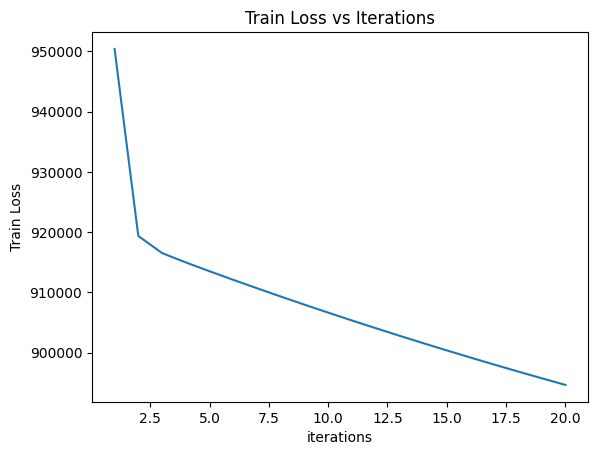

In [32]:
import matplotlib.pyplot as plt
# plt.plot(range(0, len(losses)), losses[:])
plt.plot(range(1, len(losses)), losses[1:])
plt.xlabel('iterations')
plt.ylabel('Train Loss')
plt.title('Train Loss vs Iterations')

Text(0.5, 1.0, 'Test Loss vs Iterations')

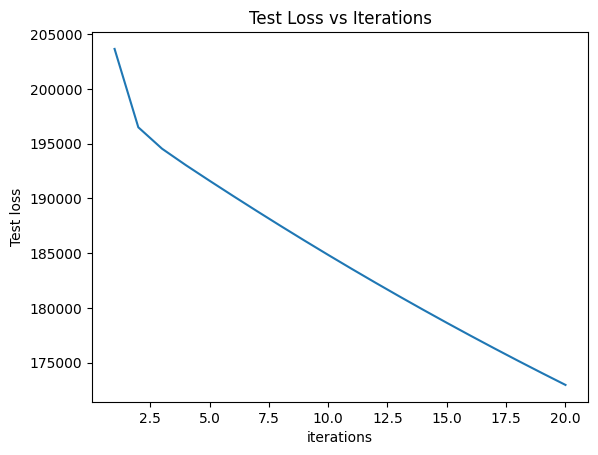

In [33]:
import matplotlib.pyplot as plt
# plt.plot(range(len(test_losses)), test_losses)
plt.plot(range(1, len(test_losses)), test_losses[1:])
plt.xlabel('iterations')
plt.ylabel('Test loss')
plt.title('Test Loss vs Iterations')

Text(0.5, 1.0, 'Train RMSE vs Iterations')

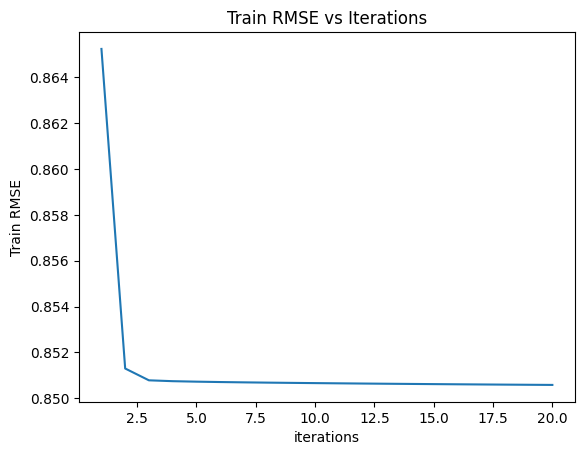

In [34]:
import matplotlib.pyplot as plt
# plt.plot(range(len(rmses)), rmses)
plt.plot(range(1, len(rmses)), rmses[1:])
plt.xlabel('iterations')
plt.ylabel('Train RMSE')
plt.title('Train RMSE vs Iterations')

Text(0.5, 1.0, 'Test RMSE vs Iterations')

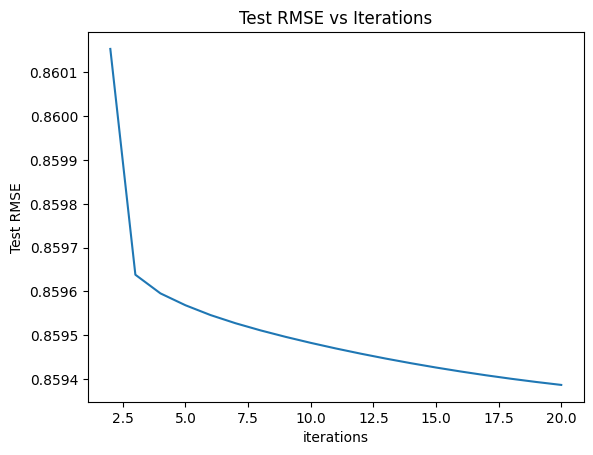

In [35]:
import matplotlib.pyplot as plt
# plt.plot(range(len(test_rmses)), test_rmses)
plt.plot(range(2, len(test_rmses)), test_rmses[2:])

plt.xlabel('iterations')
plt.ylabel('Test RMSE')
plt.title('Test RMSE vs Iterations')

Text(0.5, 1.0, 'RMSE vs Iterations')

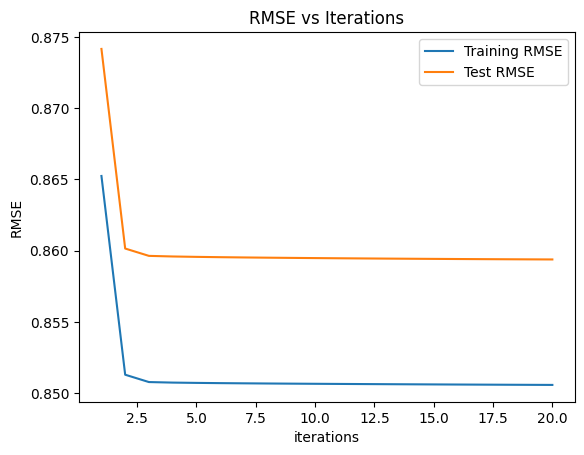

In [36]:
import matplotlib.pyplot as plt
# plt.plot(range(len(rmses)), rmses, label = 'Training RMSE')
# plt.plot(range(len(test_rmses)), test_rmses, label = 'Test RMSE')
plt.plot(range(1, len(rmses)), rmses[1:], label = 'Training RMSE')
plt.plot(range(1, len(test_rmses)), test_rmses[1:], label = 'Test RMSE')
plt.legend()
plt.xlabel('iterations')
plt.ylabel('RMSE')
plt.title('RMSE vs Iterations')

In [37]:
print(user_bias.max())
print(movie_bias.max())

5.330506254010331
1.9212868298049328


# Biases + Embeddings

In [38]:
def loss(ds, U, V, user_bias, movie_bias, lamda, taw, gamma, train=True):
  cost = 0
  for user in range(len(ds.train_users_list)):
    for movie, rating in ds.get_movies_by_user(user, train):
      cost += (rating - (np.dot(U[user], V[movie]) + user_bias[user] + movie_bias[movie])) ** 2
  cost *= lamda / 2

  cost += taw / 2 * np.sum(U ** 2)
  cost += taw / 2 * np.sum(V ** 2)

  # cost += gamma / 2 * sum([x ** 2 for x in user_bias])
  # cost += gamma / 2 * sum([x ** 2 for x in movie_bias])
  cost += gamma / 2 * np.dot(user_bias, user_bias)
  cost += gamma / 2 * np.dot(movie_bias, movie_bias)

  return cost

In [39]:
def rmse(ds, U, V, user_bias, movie_bias, train=True):
  cost = 0
  count = 0
  for user in range(len(ds.train_users_list)):
    user_ratings = ds.get_movies_by_user(user, train)
    # if not user_ratings:
    #   continue
    for movie, rating in user_ratings:
      cost += (rating - (np.dot(U[user], V[movie]) + user_bias[user] + movie_bias[movie])) ** 2
      count += 1

  cost /= count
  return np.sqrt(cost)

In [40]:
def als_loop(ds, U, V, user_bias, movie_bias, lamda, taw, gamma):
  num_users = len(user_bias)
  num_movies = len(movie_bias)
  num_factors = U.shape[1]

  # Updating users biases and and latent factors
  for user in range(num_users):
    # Updating User bias
    bias = 0
    user_ratings = ds.get_movies_by_user(user)
    if not user_ratings:
      continue
    # print('user:', user, len(user_ratings))
    for movie, rating in user_ratings:
      bias += rating - (np.dot(U[user], V[movie]) + movie_bias[movie])
    bias *= lamda
    bias /= (lamda * len(user_ratings) + gamma)
    user_bias[user] = bias

    # Updating User Latent Factors
    matrix = np.zeros((num_factors, num_factors))
    vector = np.zeros(num_factors)
    # print('no.of movies watched =', len(user_ratings))
    for movie, rating in user_ratings:
      # print('V[movie] =', V[movie])
      matrix += np.outer(V[movie], V[movie])
      # Fix here ************************************************************************************
      vector += V[movie] * (rating - user_bias[user] - movie_bias[movie])

    matrix *= lamda
    matrix += taw * np.eye(num_factors)
    # print('matrix =', matrix)
    try:
      matrix = np.linalg.inv(matrix)
    except:
      print('userIdx =', user)
      print('matrix =', matrix)
      raise Exception('Singular Matrix')
    vector *= lamda
    U[user] = np.dot(matrix, vector)


  # Updating movies biases and latent factors
  for movie in range(num_movies):

    # Updating Movie bias
    bias = 0
    movie_ratings = ds.get_users_by_movie(movie)
    if not movie_ratings:
      continue
    for user, rating in movie_ratings:
      bias += rating - (np.dot(U[user], V[movie]) + user_bias[user])
    bias *= lamda
    bias /= (lamda * len(movie_ratings) + gamma)
    movie_bias[movie] = bias

    # Updating Movie Latent Factors
    matrix = np.zeros((num_factors, num_factors))
    vector = np.zeros(num_factors)
    # print('no.of users who watched =', len(movie_ratings))
    for user, rating in movie_ratings:
      matrix += np.outer(U[user], U[user])
      vector += U[user] * (rating - user_bias[user] - movie_bias[movie])

    matrix *= lamda
    matrix += taw * np.eye(num_factors)
    # print('matrix =', matrix)
    try:
      matrix = np.linalg.inv(matrix)
    except:
      print('movieIdx =', movie)
      print('matrix =', matrix)
      raise Exception('Singular Matrix')
    vector *= lamda
    V[movie] = np.dot(matrix, vector)


  return U, V, user_bias, movie_bias

In [42]:
import time
def als(ds, lamda = 0.01, taw = 0.03, gamma = 0.01, iters = 15):
  # lamda = 0.01
  # taw = 0.03
  # gamma = 0.01
  num_factors = 20
  # iters = 15
  num_users = len(ds.train_users_list)
  num_movies = len(ds.train_movies_list)
  # U = np.zeros((num_users, num_factors))
  # V = np.zeros((num_movies, num_factors))
  # U = np.random.rand(num_users, num_factors)
  # V = np.random.rand(num_movies, num_factors)
  U = np.random.normal(0, 1 / np.sqrt(num_factors), (num_users, num_factors))
  V = np.random.normal(0, 1 / np.sqrt(num_factors), (num_movies, num_factors))
  user_bias = np.zeros(num_users)
  movie_bias = np.zeros(num_movies)
  # user_bias = np.random.random((num_users))
  # movie_bias = np.random.random((num_movies))

  losses = []
  test_losses = []
  rmses = []
  test_rmses = []
  losses.append(loss(ds, U, V, user_bias, movie_bias, lamda, taw, gamma, True))
  test_losses.append(loss(ds, U, V, user_bias, movie_bias, lamda, taw, gamma, False))
  rmses.append(rmse(ds, U, V, user_bias, movie_bias, True))
  test_rmses.append(rmse(ds, U, V, user_bias, movie_bias, False))
  total_time = 0
  for i in range(iters):
    tic = time.time()
    U, V, user_bias, movie_bias = als_loop(ds, U, V, user_bias, movie_bias, lamda, taw, gamma)
    toc = time.time()
    duration = (toc - tic) / 60
    total_time += duration
    losses.append(loss(ds, U, V, user_bias, movie_bias, lamda, taw, gamma, True))
    test_losses.append(loss(ds, U, V, user_bias, movie_bias, lamda, taw, gamma, False))
    rmses.append(rmse(ds, U, V, user_bias, movie_bias, True))
    test_rmses.append(rmse(ds, U, V, user_bias, movie_bias, False))
    print('iter =', i+1, '\t', 'duration =', round(duration, 2), 'mins', '\tloss =', round(losses[-1], 1), '\tTest Loss =', round(test_losses[-1], 1), '\tTrain RMSE =', round(rmses[-1], 3), '\tTest RMSE =', round(test_rmses[-1], 2))

  print('Total time =', total_time, 'mins')

  return U, V, user_bias, movie_bias, losses, test_losses, rmses, test_rmses

In [43]:
U, V, user_bias, movie_bias, losses, test_losses, rmses, test_rmses = als(my_ds)

iter = 1 	 duration = 6.97 mins 	loss = 86215.5 	Test Loss = 24259.6 	Train RMSE = 0.801 	Test RMSE = 0.9
iter = 2 	 duration = 8.06 mins 	loss = 73233.8 	Test Loss = 22817.4 	Train RMSE = 0.727 	Test RMSE = 0.85
iter = 3 	 duration = 6.95 mins 	loss = 67723.8 	Test Loss = 21830.8 	Train RMSE = 0.695 	Test RMSE = 0.82
iter = 4 	 duration = 7.97 mins 	loss = 65175.6 	Test Loss = 21228.7 	Train RMSE = 0.68 	Test RMSE = 0.81
iter = 5 	 duration = 7.15 mins 	loss = 63707.9 	Test Loss = 20785.1 	Train RMSE = 0.673 	Test RMSE = 0.8
iter = 6 	 duration = 7.09 mins 	loss = 62726.4 	Test Loss = 20424.5 	Train RMSE = 0.668 	Test RMSE = 0.8
iter = 7 	 duration = 8.11 mins 	loss = 62007.5 	Test Loss = 20116.8 	Train RMSE = 0.665 	Test RMSE = 0.8
iter = 8 	 duration = 7.81 mins 	loss = 61448.9 	Test Loss = 19846.6 	Train RMSE = 0.663 	Test RMSE = 0.79
iter = 9 	 duration = 7.75 mins 	loss = 60996.3 	Test Loss = 19604.6 	Train RMSE = 0.662 	Test RMSE = 0.79
iter = 10 	 duration = 7.68 mins 	loss = 6

In [44]:
print(losses)

[1540453.6233002443, 86215.46928225688, 73233.84706367136, 67723.7762098148, 65175.5836977062, 63707.92008971262, 62726.35891503234, 62007.49525951979, 61448.871440270246, 60996.27177952309, 60617.576233786276, 60292.425005358244, 60007.421041245114, 59753.484421764566, 59524.270256771924, 59315.19957995002]


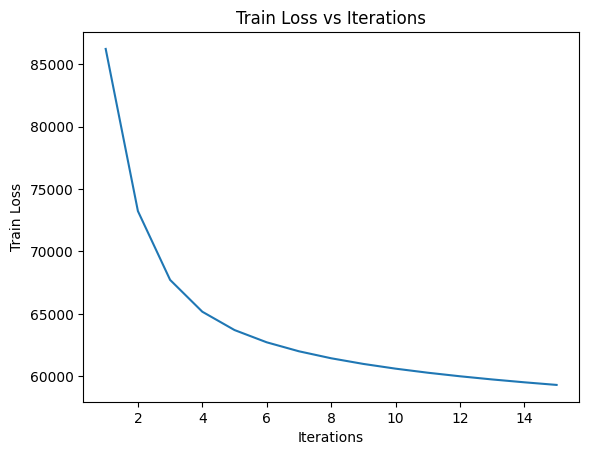

In [67]:
import matplotlib.pyplot as plt
# plt.plot(range(0, len(losses)), losses[:])
plt.plot(range(1, len(losses)), losses[1:])
plt.xlabel('Iterations')
plt.ylabel('Train Loss')
plt.title('Train Loss vs Iterations')
plt.savefig('loss_vs_iter.svg')
plt.savefig('loss_vs_iter.png')

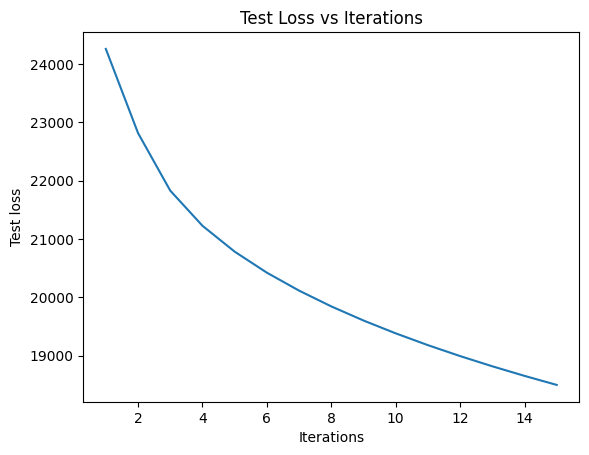

In [69]:
import matplotlib.pyplot as plt
# plt.plot(range(len(test_losses)), test_losses)
plt.plot(range(1, len(test_losses)), test_losses[1:])
plt.xlabel('Iterations')
plt.ylabel('Test loss')
plt.title('Test Loss vs Iterations')
plt.savefig('test_loss_vs_iter.svg')
plt.savefig('test_loss_vs_iter.png')

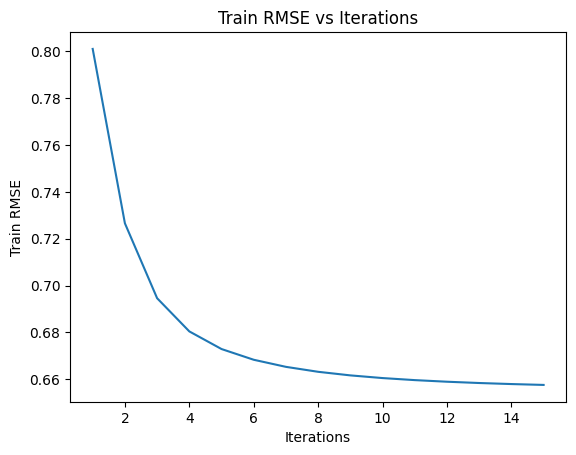

In [72]:
import matplotlib.pyplot as plt
# plt.plot(range(len(rmses)), rmses)
plt.plot(range(1, len(rmses)), rmses[1:])
plt.xlabel('Iterations')
plt.ylabel('Train RMSE')
plt.title('Train RMSE vs Iterations')
plt.savefig('rmse_vs_iter.svg')
plt.savefig('rmse_vs_iter.png')

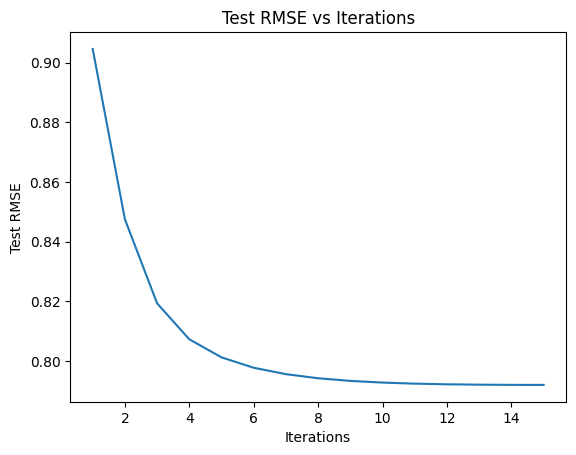

In [73]:
import matplotlib.pyplot as plt
# plt.plot(range(len(test_rmses)), test_rmses)
plt.plot(range(1, len(test_rmses)), test_rmses[1:])

plt.xlabel('Iterations')
plt.ylabel('Test RMSE')
plt.title('Test RMSE vs Iterations')
plt.savefig('test_rmse_vs_iter.svg')
plt.savefig('test_rmse_vs_iter.png')

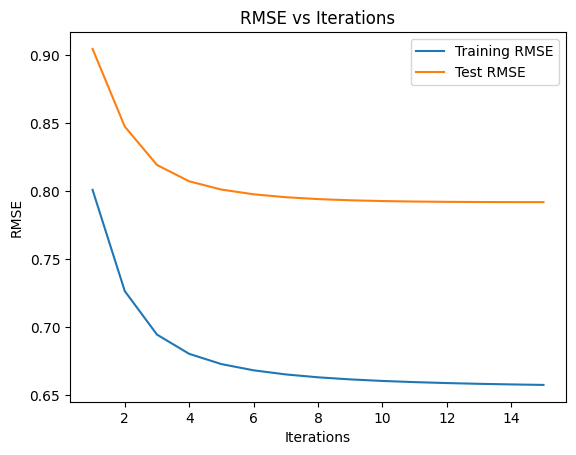

In [74]:
import matplotlib.pyplot as plt
# plt.plot(range(len(rmses)), rmses, label = 'Training RMSE')
# plt.plot(range(len(test_rmses)), test_rmses, label = 'Test RMSE')
plt.plot(range(1, len(rmses)), rmses[1:], label = 'Training RMSE')
plt.plot(range(1, len(test_rmses)), test_rmses[1:], label = 'Test RMSE')
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('RMSE vs Iterations')
plt.savefig('combined_rmse_vs_iter.svg')
plt.savefig('combined_rmse_vs_iter.png')

In [53]:
import pickle

In [54]:
with open('Users_Factors.pkl', 'wb') as file:
    pickle.dump(U, file)

In [55]:
with open('Movies_Factors.pkl', 'wb') as file:
    pickle.dump(V, file)

In [56]:
with open('My_Ds.pkl', 'wb') as file:
    pickle.dump(my_ds, file)

In [59]:
with open('Users_biases.pkl', 'wb') as file:
    pickle.dump(user_bias, file)

In [60]:
with open('Movies_biases.pkl', 'wb') as file:
    pickle.dump(movie_bias, file)

In [58]:
with open('Losses.pkl', 'wb') as file:
    pickle.dump(losses, file)

In [61]:
with open('Test_Losses.pkl', 'wb') as file:
    pickle.dump(test_losses, file)

In [64]:
with open('Rmses.pkl', 'wb') as file:
    pickle.dump(rmses, file)

In [65]:
with open('Test_Rmses.pkl', 'wb') as file:
    pickle.dump(test_rmses, file)